# Notes

First iteration is to model: goal to have end to end pipeline from data to dynamics for a patient
- Don't have test train split
- Predict on training data
- Entry is an exercise
- Include exercise meta like https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ 

In [1]:
import os 
import re
import csv
import json
from datetime import datetime

import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Constants

In [2]:
SEQ_MAX_LEN = 600
NUM_CLASSES = 6
NUM_EXERCISES = 9
NUM_FLAG_BS = 2

In [3]:
dir_data_root = os.path.join('..', 'data')
dir_exercises = os.path.join(dir_data_root, 'json', 'exercises_raw')
dir_exercises = os.path.join(dir_data_root, 'json', 'exercises_raw')
dir_patiens_sessions = os.path.join(dir_data_root, 'json', 'patients_sessions')

# Data prep

### Build training set

In [4]:
def exercise_to_input(file_path):
    with open(file_path, 'r') as f_r:
        exercise = json.load(f_r)
        
        exercise_sequence = []

        for poi in sorted(exercise['pois'].keys()):
            sequences = exercise['pois'][poi]
            exercise_sequence.append(sequences['xs'])
            exercise_sequence.append(sequences['ys'])
            exercise_sequence.append(sequences['zs'])
    
        exercise_sequence = pad_sequences(
            exercise_sequence,
            padding="pre",
            maxlen=SEQ_MAX_LEN)
    
    x_a_1 = [0] * NUM_EXERCISES
    x_a_2 = [0] * NUM_FLAG_BS
    x_a_1[exercise['meta']['id']] = 1
    x_a_2[exercise['meta']['flag_before_surgery']] = 1

    return x_a_1 + x_a_2, exercise_sequence, exercise['meta']['evaluation']

In [5]:
xslist_a = list()
xslist_b = list()
yslist = list()

for file_name in os.listdir(dir_exercises):
    file_path = os.path.join(dir_exercises, file_name)
    
    if file_name == '.DS_Store': continue

    xs_a, xs_b, ys = exercise_to_input(file_path)
    
    yslist.append(ys)
    xslist_a.append(xs_a)  
    xslist_b.append(xs_b)
    
    #break
            
ys = np.array(yslist)
xs_a = np.array(xslist_a)   
xs_b = np.array(xslist_b) 


print(ys.shape)
print(xs_a.shape)
print(xs_b.shape)

(1029,)
(1029, 11)
(1029, 63, 600)


## Modeling

In [6]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [7]:
chanDim = -1
    
inputA = Input(shape=xs_a.shape[1:])
inputB = Input(shape=xs_b.shape[1:])

x_a = Dense(4, activation="relu")(inputA)
x_a = Model(inputs=inputA, outputs=x_a)

#x_b = LSTM(64)(inputB)
x_b = Conv1D(16, 3, padding='same', activation='relu')(inputB)
x_b = BatchNormalization(axis=chanDim)(x_b)
x_b = MaxPooling1D((2))(x_b)
x_b = Conv1D(32, 3, padding='same', activation='relu')(x_b)
x_b = BatchNormalization(axis=chanDim)(x_b)
x_b = MaxPooling1D((2))(x_b)
x_b = Conv1D(64, 3, padding='same', activation='relu')(x_b)
x_b = BatchNormalization(axis=chanDim)(x_b)
x_b = MaxPooling1D((2))(x_b)
x_b = Conv1D(64, 3, padding='same', activation='relu')(x_b)
x_b = BatchNormalization(axis=chanDim)(x_b)
x_b = MaxPooling1D((2))(x_b)
x_b = Flatten()(x_b)
x_b = Dropout(0.5)(x_b)
x_b = Dense(128, activation="relu")(x_b)
x_b = Model(inputs=inputB, outputs=x_b)

combined = concatenate([x_a.output, x_b.output])
x = Dense(32, activation="relu")(combined)
x = Dense(6, activation="softmax")(x)
model = Model(inputs=[x_a.input, x_b.input], outputs=x)

model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=Adam(lr=1e-3, decay=1e-3 / 200),
    metrics=['accuracy']
)

model.summary()

Metal device set to: Apple M1


2023-04-17 08:51:35.612429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-17 08:51:35.612822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 63, 600)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 63, 16)       28816       ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 16)      64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 31, 16)       0           ['batch_normalization[0][0]

In [8]:
print(set(ys))

{0, 1, 2, 3, 4, 5}


In [9]:
weight_training_classes = {0: 0.32075471698113206, 
                           1: 1.1333333333333333,
                           2: 1.3076923076923077, 
                           3: 3.4, 
                           4: 3.4,
                           5: 1.5454545454545454}

In [10]:
model.fit(
    x=[xs_a, xs_b], y=ys, 
    validation_data=([xs_a, xs_b], ys),
    batch_size=8, epochs=100,
    class_weight=weight_training_classes)

Epoch 1/100


2023-04-17 08:51:35.934488: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-17 08:51:36.644895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - ETA: 0s - loss: 1.9995 - accuracy: 0.1837

2023-04-17 08:51:39.847472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 5s 26ms/step - loss: 1.9995 - accuracy: 0.1837 - val_loss: 1.6974 - val_accuracy: 0.1652
Epoch 2/100
129/129 [==============================] - 3s 22ms/step - loss: 1.8901 - accuracy: 0.1749 - val_loss: 1.7462 - val_accuracy: 0.1914
Epoch 3/100
129/129 [==============================] - 3s 21ms/step - loss: 1.8139 - accuracy: 0.1827 - val_loss: 1.7146 - val_accuracy: 0.2157
Epoch 4/100
129/129 [==============================] - 3s 21ms/step - loss: 1.7920 - accuracy: 0.2080 - val_loss: 1.6694 - val_accuracy: 0.2293
Epoch 5/100
129/129 [==============================] - 3s 22ms/step - loss: 1.8051 - accuracy: 0.2080 - val_loss: 1.8578 - val_accuracy: 0.1487
Epoch 6/100
129/129 [==============================] - 3s 21ms/step - loss: 1.7578 - accuracy: 0.2177 - val_loss: 1.7711 - val_accuracy: 0.1623
Epoch 7/100
129/129 [==============================] - 3s 21ms/step - loss: 1.7768 - accuracy: 0.1720 - val_loss: 1.6295 - val_accuracy: 0.2750
Epoc

In [11]:
from sklearn.metrics import classification_report

y_pred = model.predict([xs_a, xs_b],verbose=0)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(ys, y_pred_bool))

2023-04-17 08:56:19.113323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.99      0.75      0.85       490
           1       0.77      0.97      0.86       180
           2       0.72      0.99      0.83       135
           3       0.91      0.98      0.94        52
           4       0.94      1.00      0.97        45
           5       0.85      0.95      0.90       127

    accuracy                           0.87      1029
   macro avg       0.86      0.94      0.89      1029
weighted avg       0.89      0.87      0.87      1029



# Patient dynamics

In [81]:
from operator import attrgetter

In [82]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

In [83]:
weights = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
exercises_number = 9

## Single patient with details

In [84]:
patient_id = '00000000020'

In [85]:
sessions = []
with open(os.path.join(dir_patiens_sessions, '%s.json' % patient_id), 'r') as f_r:
    sessions = json.load(f_r)
    
print(sessions)

[{'id': 0, 'exercise_dates': '2019-06-03', 'evaluation': 0, 'flag_before_surgery': 1, 'number_of_exercises': 9}, {'id': 1, 'exercise_dates': '2019-08-29', 'evaluation': 1, 'flag_before_surgery': 1, 'number_of_exercises': 9}]


In [86]:
sessions.sort(key=lambda x: x['exercise_dates'])
print(sessions)

[{'id': 0, 'exercise_dates': '2019-06-03', 'evaluation': 0, 'flag_before_surgery': 1, 'number_of_exercises': 9}, {'id': 1, 'exercise_dates': '2019-08-29', 'evaluation': 1, 'flag_before_surgery': 1, 'number_of_exercises': 9}]


1


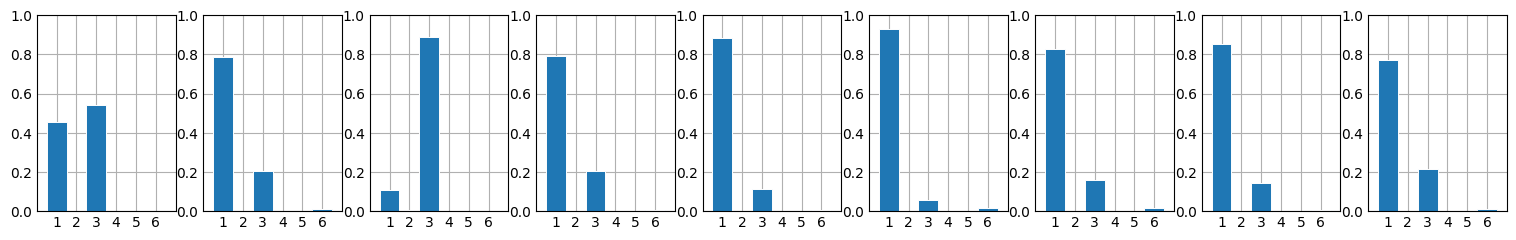

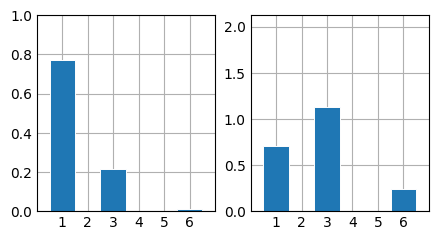

2


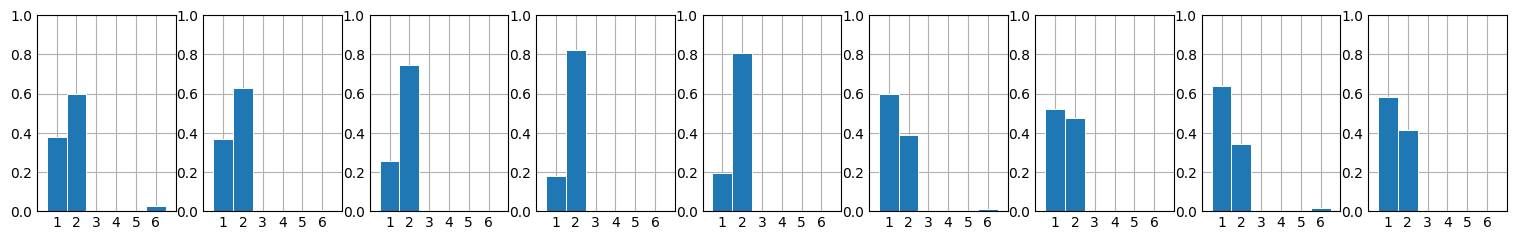

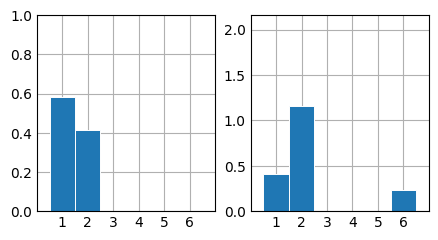

[2.077481921240178, 1.809907286435191]


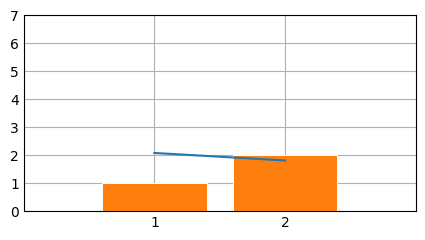

In [87]:
dynamic = []
evaluations = []

for session in sessions:
    exercises_result = []
    print(session['evaluation'] + 1) #from index to class
    evaluations.append(session['evaluation'] + 1)

    fig, axs = plt.subplots(1,9,figsize=(15,2)) 

    for exercise_id in range(exercises_number):
        file_name = os.path.join(
            dir_exercises, '%s_%s_%s.json' % (
                patient_id, 
                session['id'],
                exercise_id))
        
        if not os.path.isfile(file_name):
            continue
            
        xs_a, xs_b, ys = exercise_to_input(file_name)
        
        xs_a = np.array([xs_a])   
        xs_b = np.array([xs_b]) 
        
        #print(xs_a.shape)
        #print(xs_b.shape)
        
        
        y_pred = model.predict([xs_a, xs_b], verbose=0)
        exercises_result.append(list(y_pred[0]))
        
                
        axs[exercise_id].bar(1 + np.arange(6), y_pred[0], width=1, edgecolor="white", linewidth=0.7)

        axs[exercise_id].set(
            xlim=(0, 7), 
            xticks=np.arange(1, 7),
            ylim=(0, 1))
    
    #average session 
    prediction = np.average(np.array(exercises_result), axis=0)
    exercise_score = [y*w for y, w in zip(prediction,weights)]
    dynamic.append(sum(exercise_score))
    
    fig, axs = plt.subplots(1,2,figsize=(4,2)) 
        
    x = 1 + np.arange(6)
    y_pred = y_pred[0]
    y_score = exercise_score

    axs[0].bar(x, y_pred, width=1, edgecolor="white", linewidth=0.7)

    axs[0].set(xlim=(0, 7), 
              xticks=np.arange(1, 7),
              ylim=(0, 1), 
             )


    axs[1].bar(x, y_score, width=1, edgecolor="white", linewidth=0.7)
    axs[1].set(xlim=(0, 7), 
              xticks=np.arange(1, 7),
              ylim=(0, max(y_score) + 1), 
             )

    plt.show()    
        

print(dynamic)
fig, ax = plt.subplots(figsize=(4,2)) 

x = 1 + np.arange(len(sessions))
y = dynamic

#ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)
ax.plot(x, y, color='tab:blue')
ax.bar(x, evaluations, color='tab:orange', edgecolor="white", linewidth=0.7)

ax.set(xlim=(0, len(sessions) + 1), 
          xticks=np.arange(1, len(sessions) + 1),
          ylim=(0, max(7, max(y) + 1)), 
         )

plt.show() 

## Patients Dynamics: Multiple Patients

In [96]:
def get_fine_score(patient_id):
    sessions = []
    fine_score = []
    evaluations = []

    with open(os.path.join(dir_patiens_sessions, '%s.json' % patient_id), 'r') as f_r:
        sessions = json.load(f_r)
        
    sessions.sort(key=lambda x: x['exercise_dates'])
    
    for session in sessions:
        exercises_result = []
        evaluations.append(session['evaluation'] + 1)
    
        for exercise_id in range(exercises_number):
            file_name = os.path.join(
                dir_exercises, '%s_%s_%s.json' % (
                    patient_id, 
                    session['id'],
                    exercise_id))

            if not os.path.isfile(file_name):
                continue

            xs_a, xs_b, ys = exercise_to_input(file_name)

            xs_a = np.array([xs_a])   
            xs_b = np.array([xs_b]) 

            y_pred = model.predict([xs_a, xs_b], verbose=0)
            exercises_result.append(list(y_pred[0]))

        #average session 
        prediction = np.average(np.array(exercises_result), axis=0)
        exercise_score = [y*w for y, w in zip(prediction,weights)]
        fine_score.append(sum(exercise_score))
        
    return fine_score, evaluations

In [108]:
patients = [
    '00000000034',
    '00000000074',
    '00000000058',
    '00000000039',
    '00000000081',
    '00000000042',
]

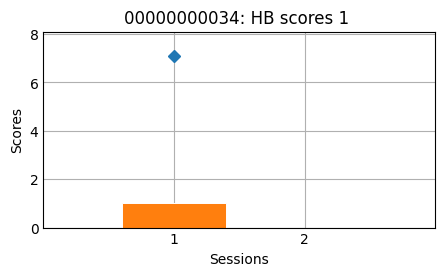

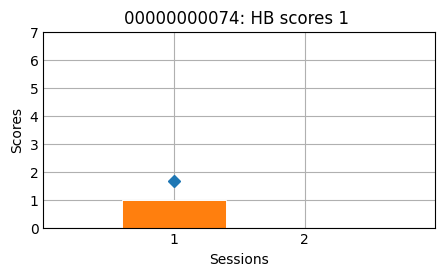

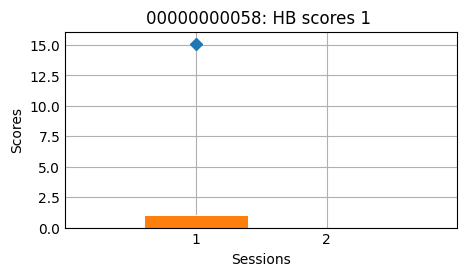

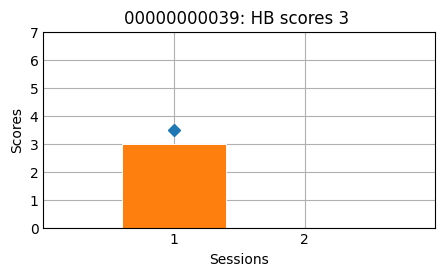

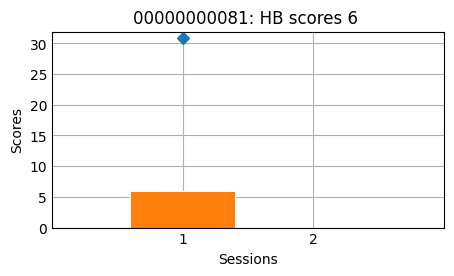

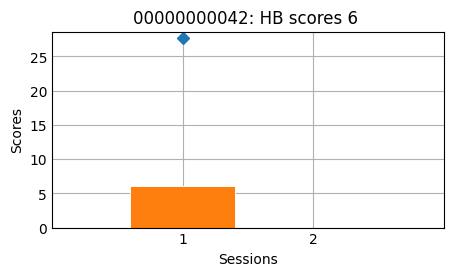

In [110]:
for patient_id in patients:
    fine_score, evaluations = get_fine_score(patient_id)
    fig, ax = plt.subplots(figsize=(4,2)) 

    x = 1 + np.arange(len(evaluations))

    ax.plot(x, fine_score, color='tab:blue', marker='D')
    ax.bar(x, evaluations, color='tab:orange', edgecolor='white', linewidth=0.7)

    ax.set(
        xlim=(0, len(sessions) + 1), 
        xticks=np.arange(1, len(sessions) + 1),
        ylim=(0, max(7, max(fine_score) + 1)),
        xlabel='Sessions',
        ylabel='Scores',
        title='%s: HB scores %s ' % (patient_id, ', '.join(map(str, evaluations)))
    )

plt.show() 

__END__